In [85]:
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../../mbspbs10pc')

from mbspbs10pc import utils

# Check MBS-PBS 10% data availability

In [87]:
ROOT = os.path.join('..','..','..','data')

mbs_files = filter(lambda x: x.startswith('MBS'), os.listdir(ROOT))
pbs_files = filter(lambda x: x.startswith('PBS'), os.listdir(ROOT))
sample_pin_lookout = filter(lambda x: x.startswith('SAMPLE'), os.listdir(ROOT))[0]

print('MBS files:')
for mbs in mbs_files:
    print('{}'.format(os.path.join(ROOT, mbs)))
    
print('PBS files:')
for pbs in pbs_files:
    print('{}'.format(os.path.join(ROOT, pbs)))
    
print('Sample PIN lookout: {}'.format(os.path.join(ROOT, sample_pin_lookout)))

MBS files:
../../../data/MBS_SAMPLE_10PCT_2013.csv
../../../data/MBS_SAMPLE_10PCT_2012.csv
../../../data/MBS_SAMPLE_10PCT_2010.csv
../../../data/MBS_SAMPLE_10PCT_2011.csv
../../../data/MBS_SAMPLE_10PCT_2014.csv
../../../data/MBS_SAMPLE_10PCT_2008.csv
../../../data/MBS_SAMPLE_10PCT_2009.csv
PBS files:
../../../data/PBS_SAMPLE_10PCT_2012.csv
../../../data/PBS_SAMPLE_10PCT_2013.csv
../../../data/PBS_SAMPLE_10PCT_2011.csv
../../../data/PBS_SAMPLE_10PCT_2010.csv
../../../data/PBS_SAMPLE_10PCT_2009.csv
../../../data/PBS_SAMPLE_10PCT_2008.csv
Sample PIN lookout: ../../../data/SAMPLE_PIN_LOOKUP.csv


# PBS take a look

In [89]:
filename = pbs_files[-1]
print(filename)
df = pd.read_csv(os.path.join(ROOT, '{}'.format(filename)), header=0, index_col=0, nrows=1000)
df.shape

PBS_SAMPLE_10PCT_2008.csv


(1000, 13)

In [90]:
df.head()

,SPPLY_DT,ITM_CD,PBS_RGLTN24_ADJST_QTY,BNFT_AMT,PTNT_CNTRBTN_AMT,SRT_RPT_IND,RGLTN24_IND,DRG_TYP_CD,MJR_SPCLTY_GRP_CD,UNDR_CPRSCRPTN_TYP_CD,PRSCRPTN_CNT,PTNT_CTGRY_DRVD_CD,PTNT_STATE
PTNT_ID,,,,,,,,,,,,,
9772479275,05MAY2008,01171P,1,3.63,5.0,NaN,N,GE,1.0,NaN,1,C1,QLD
8114957183,06JUN2008,08681X,20,14.74,5.0,NaN,N,GE,1.0,NaN,1,C1,WA
8866313366,14DEC2008,01325R,60,6.60,5.0,NaN,N,GE,1.0,NaN,1,G1,WA
8493121914,15NOV2008,02236Q,30,24.23,0.0,R,N,GE,1.0,NaN,1,C0,VIC
5124189855,01SEP2008,02745L,2,45.29,5.0,NaN,N,GE,2.0,NaN,1,G1,VIC


# Drugs used in diabetes

In [91]:
_dd = pd.read_csv(os.path.join('..', 'data', 'drugs_used_in_diabetes.csv'), header=0)

# Fix 6-digit notation
dd = set()
for item in _dd.values.ravel():
    if len(item)<6:
        dd.add(str(0)+item)
    else:
        dd.add(item)

# FIXME - exclude Metformins and Sulfonamides
dd = pd.DataFrame(data=list(dd), columns=_dd.columns)
ms = pd.read_csv(os.path.join('..', 'data', 'metformins_sulfonamides.csv'), header=0)
mask = []
for d in dd.values:
    mask.append(d not in ms.values)
dd = pd.DataFrame(data=dd.values[mask], columns=dd.columns)
print(dd.shape)

(76, 1)


In [92]:
dd.head()

,ITM_CD
0,09061X
1,09180E
2,10649L
3,01763T
4,09449H


In [93]:
dd_set = set(list(dd.values.ravel()))

# Filter diabetes

In [146]:
filename = 'PBS_SAMPLE_10PCT_2011.csv'
costs = pd.read_csv(os.path.join(ROOT, '{}'.format(filename)), header=0,
                    usecols=['BNFT_AMT', 'PTNT_CNTRBTN_AMT', 'ITM_CD', 'SPPLY_DT'])
costs.head()

,SPPLY_DT,ITM_CD,BNFT_AMT,PTNT_CNTRBTN_AMT
0,23NOV2011,09110L,28.19,0.0
1,05JUL2011,01558B,6.96,5.6
2,17SEP2011,08008L,30.71,0.0
3,23JUN2011,02843P,6.82,5.6
4,24MAR2011,08784H,5.10,0.0


In [147]:
dd_costs = costs.loc[costs['ITM_CD'].isin(dd_set)]
print(dd_costs.shape)

(215228, 4)


In [148]:
dd_costs['TOT'] = dd_costs['BNFT_AMT'] + dd_costs['PTNT_CNTRBTN_AMT']

/Users/samu/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [149]:
dd_costs.sort_values(by='TOT').head()

,SPPLY_DT,ITM_CD,BNFT_AMT,PTNT_CNTRBTN_AMT,TOT
3724230,23NOV2011,08694N,3.11,0.0,3.11
854527,26DEC2011,08838E,0.31,5.8,6.11
4705379,06OCT2011,08811R,3.54,5.6,9.14
12463310,28JAN2011,08838E,7.62,5.6,13.22
14740494,02DEC2011,08838E,7.62,5.6,13.22


Text(0.5,1,u'2011')

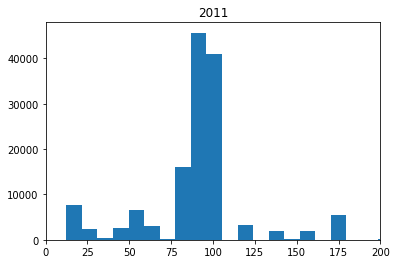

In [150]:
plt.hist(dd_costs['TOT'], bins=200)
plt.xlim([0,200])
plt.title(2011)

Text(0.5,1,u'2012')

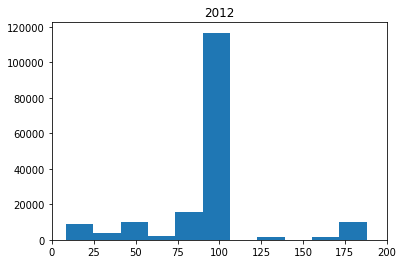

In [145]:
plt.hist(dd_costs['TOT'], bins=200)
plt.xlim([0,200])
plt.title(2012)

In [119]:
#costs[np.logical_and(costs['PTNT_CNTRBTN_AMT'] > 35.4, costs['ITM_CD'].isin(dd_set))]

In [120]:
over_copayment = []
below_copayment = []
thresholds = [31.3, 32.9, 33.3, 34.2, 35.4, 36.1]

for year, thresh in zip(np.arange(2008,2014), thresholds):
    print('Reading {}'.format(year))
    filename = 'PBS_SAMPLE_10PCT_'+str(year)+'.csv'
    costs = pd.read_csv(os.path.join(ROOT, '{}'.format(filename)), header=0,
                        usecols=['BNFT_AMT', 'PTNT_CNTRBTN_AMT', 'ITM_CD', 'SPPLY_DT'])
    dd_costs = costs.loc[costs['ITM_CD'].isin(dd_set)] # filter for diabetes
    
    c = dd_costs['BNFT_AMT'] + dd_costs['PTNT_CNTRBTN_AMT']
    
    break

Reading 2008


In [124]:
len(np.where(c > thresh)[0])

114891

In [126]:
len(c)

125842

# Costs plot

In [114]:
#idx = np.where(np.logical_and(costs['PTNT_CNTRBTN_AMT'].values > 0, costs['PTNT_CNTRBTN_AMT'].values < 50))

In [115]:
xx = dd_costs['BNFT_AMT']
print(xx.min())

0.17


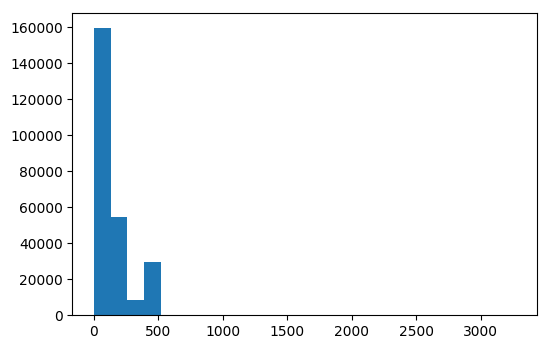

In [109]:
plt.figure(dpi=100)
plt.hist(xx, bins=25);

# Summary plots

In [151]:
import cPickle as pkl

with open('../tmp/df3.pkl','rb') as f:
    dfy = pkl.load(f)

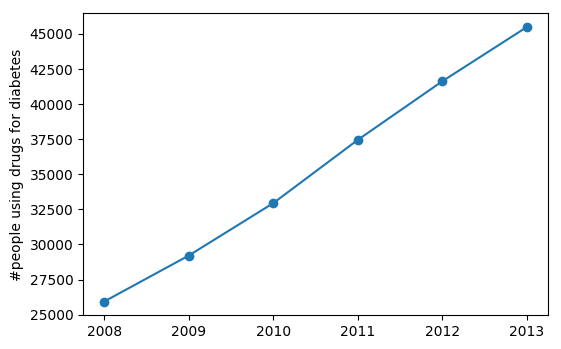

In [152]:
plt.figure(dpi=100)
lengths = [len(dfy['PBS_SAMPLE_10PCT_'+str(k)+'.csv']) for k in np.arange(2008,2014)]
plt.plot(np.arange(2008,2014), lengths, '-o')
plt.ylabel('#people using drugs for diabetes')
#plt.ylim([0, 50000])
plt.savefig('../tmp/people_using_dd.png');

In [153]:
starting = []
for target_year in np.arange(2009, 2014):
    # From the target year, go backward and find the subjects
    # that were prescribed with diabete control drugs for the
    # first time
    positive_subjects = set(dfy['PBS_SAMPLE_10PCT_'+str(target_year)+'.csv'])

    for year in np.arange(2008, target_year)[::-1]:
        curr = set(dfy['PBS_SAMPLE_10PCT_'+str(year)+'.csv'])
        positive_subjects = set(filter(lambda x: x not in curr, positive_subjects))
    starting.append(len(positive_subjects))

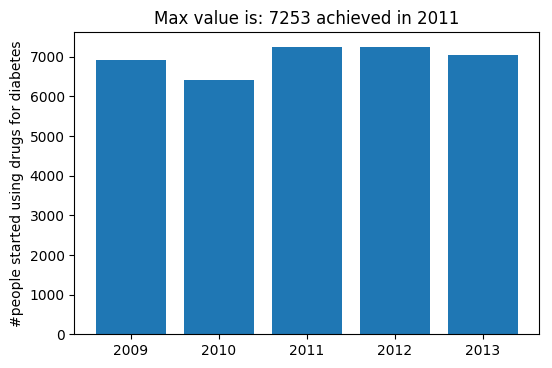

In [154]:
plt.figure(dpi=100)
plt.bar(np.arange(len(starting)), starting)
plt.xticks(np.arange(len(starting)), np.arange(2009, 2014))
plt.ylabel('#people started using drugs for diabetes')
plt.title('Max value is: {} achieved in {}'.format(np.max(starting),
                                             np.arange(2009, 2014)[np.argmax(starting)]))
plt.savefig('../tmp/people_started_using_dd.png');